# Import all the packages used

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import vampnet
from vampnet import data_generator
from tensorflow import keras
# from keras.models import Model
from tensorflow.python.keras.models import Model
from keras.layers import Dense, Activation, Flatten, Input, BatchNormalization, concatenate
# from tensorflow.python.keras.layers import Dense, Activation, Flatten, Input, BatchNormalization, concatenate
from keras import optimizers
# from tensorflow.python.keras import optimizers
import tensorflow as tf
from keras.backend import clear_session

In [ ]:
# generate 50000 frames and energy values
datapoints = int(5e4)

In [ ]:
traj_whole = data_generator.get_asymmetric_double_well_data(datapoints)
# To fit the dataformat
traj_whole = np.expand_dims(traj_whole, 1)
traj_data_points, input_size = traj_whole.shape

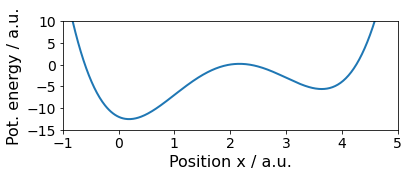

In [ ]:
x = np.linspace(-1,5,500)
plt.figure(figsize=(6,2))
plt.ylim(-15,10)
plt.xlim(-1,5)
plt.plot(x,data_generator.asymmetric_double_well_energy(x), lw = 2)
plt.xlabel('Position x / a.u.', fontsize = 16)
plt.ylabel('Pot. energy / a.u.', fontsize = 16)
plt.xticks(fontsize = 14)

plt.yticks(fontsize = 14);

In [ ]:
# All Hyperparameters

# Tau, how much is the timeshift of the two datasets
tau = 1

# Batch size for Stochastic Gradient descent
batch_size = 2048

# Which trajectory points percentage is used as training
train_ratio = 0.9

# How many hidden layers the network has
network_depth = 4

# Width of every layer
layer_width = 20
nodes = [layer_width]*network_depth
# Learning rate used for the ADAM optimizer
learning_rate = 0.0001

# How many output states the network has
output_size = 5

# Iteration over the training set in the fitting process
nb_epoch = 300

In [ ]:
epsilon = 1e-5
vamp = vampnet.VampnetTools(epsilon = epsilon)

In [ ]:
# Shuffle trajectory and lagged trajectory together
length_data = traj_data_points - tau

traj_ord= traj_whole[:length_data]
traj_ord_lag = traj_whole[tau:length_data+tau]

indexes = np.arange(length_data)
np.random.shuffle(indexes)



traj = traj_ord[indexes]
traj_lag = traj_ord_lag[indexes]


In [ ]:
# Prepare data for tensorflow usage
length_train = int(np.floor(length_data * train_ratio))
length_vali = length_data - length_train

traj_data_train = traj[:length_train]
traj_data_train_lag = traj_lag[:length_train]

traj_data_valid = traj[length_train:]
traj_data_valid_lag = traj_lag[length_train:]

#Data used for states ordering
X1 = traj_ord[:length_data].astype('float32')
X2 = traj_ord_lag[:length_data].astype('float32')

# Input of the first network
X1_train = traj_data_train.astype('float32')
X2_train  = traj_data_train_lag.astype('float32')

# Input for validation
X1_vali = traj_data_valid.astype('float32')
X2_vali = traj_data_valid_lag.astype('float32')

# Needs a Y-train set which we dont have.
Y_train = np.zeros((length_train,2*output_size)).astype('float32')
Y_vali = np.zeros((length_vali,2*output_size)).astype('float32')

In [ ]:
pip list | grep tensorflow

tensorflow                   2.9.1
tensorflow-estimator         2.9.0
tensorflow-io-gcs-filesystem 0.26.0
Note: you may need to restart the kernel to use updated packages.


In [ ]:
if 'model' in globals():
    del model
    clear_session()
# Build the model
Data_X = Input(shape = (input_size,))
Data_Y = Input(shape = (input_size,))

# A batch normalization layer improves convergence speed
#     bn_layer = BatchNormalization()
bn_layer = Activation('linear')

# Instance layers and assign them to the two lobes of the network
dense_layers = [Dense(node, activation = 'relu',)
                for node in nodes]

lx_branch = bn_layer(Data_X)
rx_branch = bn_layer(Data_Y)

for i, layer in enumerate(dense_layers):

    lx_branch = dense_layers[i](lx_branch)
    rx_branch = dense_layers[i](rx_branch)


# Add a softmax output layer.
# Should be replaced with a linear activation layer if
# the outputs of the network cannot be interpreted as states
softmax = Dense(output_size, activation='softmax')

lx_branch = softmax(lx_branch)
rx_branch = softmax(rx_branch)

# Merge both networks to train both at the same time
merged = concatenate([lx_branch, rx_branch])

# Initialize the model and the optimizer, and compile it with
# the loss and metric functions from the VAMPnets package
model = Model(inputs = [Data_X, Data_Y], outputs = merged)
#     model.summary()
# Compile it with our own loss-function
adam = optimizers.Adam(lr = learning_rate)


# Pretraining with VAMP with 'symmetrized' matrices yields a bad approximation of the 
# eigenvectors per se, but improves the 'readability' of the states identified by VAMP-2
# which would otherwise be difficult to interprete.


# IMPORTANT: the function vamp.loss_VAMP2_autograd can only be used with tensorflow 1.6 or more recent.
# For older versions of TF, use the function vamp.loss_VAMP2

losses = [
    vamp._loss_VAMP_sym,
    vamp.loss_VAMP2,
]

valid_metric = np.zeros((len(losses), nb_epoch))
train_metric = np.zeros((len(losses), nb_epoch))

for l_index, loss in enumerate(losses):
    
    model.compile(optimizer = 'adam', loss = loss, metrics = [vamp.metric_VAMP])
    
    hist = model.fit([X1_train, X2_train], Y_train ,batch_size=batch_size, epochs=nb_epoch, verbose=0,
                     validation_data=([X1_vali, X2_vali], Y_vali))
    
    temp = model.predict([traj_ord, traj_ord_lag], batch_size=np.shape(X1_vali)[0])
    
    x_a = temp[:,:output_size]


    X_Validation = np.squeeze(traj_ord)
    for i in range(output_size):
        plt.scatter(X_Validation, x_a[:,i], label= 'state '+str(i))
    plt.title('State probabilities')
    plt.legend()
    plt.show()




    states_prob_meanfree = x_a  - np.mean(x_a, axis=0)
    tau_msm = 5
    K_smt = vamp.estimate_koopman_op(states_prob_meanfree, tau_msm)

    K_eigvals, K_eigvec = np.linalg.eig(np.real(K_smt))

    index = np.argmax(np.real(K_eigvals))
    real_eigfunc = states_prob_meanfree @ np.real(K_eigvec[:,index])

    plt.scatter(X_Validation, real_eigfunc)
    plt.title('Eigenvector')
    plt.show()

    valid_metric[l_index] = np.array(hist.history['val_metric_VAMP'])
    train_metric[l_index] = np.array(hist.history['metric_VAMP'])

valid_metric = np.reshape(valid_metric, (-1))
train_metric = np.reshape(train_metric, (-1))

AttributeError: in user code:

    File "/Users/maya/Desktop/lab/deeptime/deeptime/vampnet/vampnet/vampnet.py", line 805, in _loss_VAMP_sym  *
        cov_00_ir, cov_01  = self._build_vamp_matrices_rev(x, y, batch_size)
    File "/Users/maya/Desktop/lab/deeptime/deeptime/vampnet/vampnet/vampnet.py", line 758, in _build_vamp_matrices_rev  *
        auto_cov_inv_root = self._inv(auto_cov, ret_sqrt=True)
    File "/Users/maya/Desktop/lab/deeptime/deeptime/vampnet/vampnet/vampnet.py", line 609, in _inv  *
        eigval_all, eigvec_all = tf.SelfAdjointEig(x)

    AttributeError: module 'tensorflow' has no attribute 'SelfAdjointEig'


# Training result visualization

In [ ]:
plt.plot(train_metric, label = 'Training')
plt.legend()
plt.plot(valid_metric, label = 'Validation')
plt.legend()

plt.show()

# Transform the input trajectory using the network

In [ ]:
states_prob = model.predict([traj_ord, traj_ord_lag])[:, :output_size]

# Order the output states based on their population
coor_pred = np.argmax(states_prob, axis = 1)
indexes = [np.where(coor_pred == np.multiply(np.ones_like(coor_pred), n)) for n in range(output_size)]
states_num = [len(i[0]) for i in indexes]
states_order = np.argsort(states_num).astype('int')[::-1]

pred_ord = states_prob[:,states_order]

# Visualize the population of the states

In [ ]:
def print_states_pie_chart():
    coors = []
    maxi = np.max(pred_ord, axis= 1)

    for i in range(output_size):
        coors.append(len(np.where(pred_ord[:,i] == maxi)[0]))
        
    fig1, ax1 = plt.subplots()
    ax1.pie(np.array(coors), autopct='%1.2f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    print('States population: '+str(np.array(coors)/len(maxi)*100)+'%')
    plt.show()

print_states_pie_chart()

# Estimate the implied timescales

In [ ]:
max_tau = 15
lag = np.arange(1, max_tau, 1)
its = vamp.get_its(pred_ord, lag)
vamp.plot_its(its, lag)

# Chapman-Kolmogorov test for the estimated koopman operator

In [ ]:
steps = 16
tau_msm = 1
predicted, estimated = vamp.get_ck_test(pred_ord, steps, tau_msm)
vamp.plot_ck_test(predicted, estimated, output_size, steps, tau_msm)